# 交通取締りデータコンペ

## コンペ概要
今回のコンペで使用するのは, アメリカのコネチカット州において警察のドライバー取締り状況をまとめたデータです.
train.csvのデータをもとに, test.csvの各データに対して逮捕される確率を予測してください.

## データについて
各カラムの意味は以下の通りです.
<table>
  <tr>
    <td>カラム名</td>
    <td>カラムの意味</td>
    <td>値の例</td>
  </tr>
  <tr>
    <td>state</td>
    <td>州の名前</td>
    <td>CT</td>
  </tr>
  <tr>
    <td>stop_date</td>
    <td>警官がドライバーを止めた日付. 形式:  YYYY-MM-DD</td>
    <td>2013-12-27</td>
  </tr>
  <tr>
    <td>stop_time</td>
    <td>警官がドライバーを止めた時刻. 形式: HH:MM </td>
    <td>20:15</td>
  </tr>
  <tr>
    <td>location_raw</td>
    <td>位置情報の生データ</td>
    <td>Winooski</td>
  </tr>
  <tr>
    <td>county_name</td>
    <td>郡の名前</td>
    <td>Chittenden County</td>
  </tr>
  <tr>
    <td>county_fips</td>
    <td>FIPS郡コード</td>
    <td>50007</td>
  </tr>
  <tr>
    <td>fine_grained_location</td>
    <td>詳細な位置情報データ</td>
    <td>90400 I 89 N; EXIT 15 MM90/40</td>
  </tr>
  <tr>
    <td>police_department</td>
    <td>ドライバーを止めた警察の部門</td>
    <td>WILLISTON VSP</td>
  </tr>
  <tr>
    <td>driver_gender</td>
    <td>ドライバーの性別(M, F, or NA)</td>
    <td>M</td>
  </tr>
  <tr>
    <td>driver_age_raw</td>
    <td>ドライバーの年齢の生データ</td>
    <td>30</td>
  </tr>
  <tr>
    <td>driver_age</td>
    <td>ドライバーの年齢の生データで15歳未満と100歳以上はNAにしたもの</td>
    <td>23</td>
  </tr>
  <tr>
    <td>driver_race_raw</td>
    <td>ドライバーの人種の生データ</td>
    <td>White</td>
  </tr>
  <tr>
    <td>driver_race</td>
    <td>White, Black, Hispanic, Asian, Other,  NAのいづれかの値をとる.
    NAは不明, Asianは太平洋の島々に住む人とインド人も含む. 原住民族はotherに含む.</td>
    <td>Black</td>
  </tr>
  <tr>
    <td>violation_raw</td>
    <td>違反内容の生データ</td>
    <td>Speeding (10–19 MPH Over Prima Facie Limit *)</td>
  </tr>
  <tr>
    <td>violation</td>
    <td>前処理済み違反内容のデータ. 複数の違反がある場合はカンマ区切り</td>
    <td>Speeding</td>
  </tr>
  <tr>
    <td>search_conducted</td>
    <td>捜索が行われたかどうか. 行われていたらTRUE.</td>
    <td>TRUE</td>
  </tr>
  <tr>
    <td>search_type_raw</td>
    <td>捜索の根拠の生データ</td>
    <td>CONSENT SEARCH CONDUCTED</td>
  </tr>
  <tr>
    <td>search_type</td>
    <td>前処理された捜索の根拠</td>
    <td>Consent</td>
  </tr>
  <tr>
    <td>contraband_found</td>
    <td>捜索の結果, 密売品が見つかったかどうか. そもそも捜索されていなければFALSE</td>
    <td>TRUE</td>
  </tr>
  <tr>
    <td>officer_id</td>
    <td>警官のid</td>
    <td>1000002754</td>
  </tr>
  <tr>
    <td>stop_duration</td>
    <td>警官がドライバーを止めた時間.</td>
    <td>1-15 min</td>
  </tr>
  <tr>
    <td>is_arrested</td>
    <td>実際に逮捕されたかどうか.</td>
    <td>TRUE</td>
  </tr>
</table>

## 評価指標
AUCで評価します.
AUCとはArea Under the Curveの略でROC曲線の下側の面積の値のことです.<br>
例えばscikit-learnでは, sklearn.metrics.roc_auc_scoreを用いると計算できます.

## データの提出形式
1行目には `is_arrested` と書いてください.
2行目以降は, test.csvの順番と対応するように各行に一つの値を書いてください.
```
is_arrested
0.5
0.5
...
0.5
```

## 賞金(図書カード)
```
1位: 25000円
2位: 18000円
3位: 7000円
```


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame,Series 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.metrics import mean_squared_error
import math
from sklearn.model_selection import RandomizedSearchCV
import scipy as sp
import copy

In [2]:
np.set_printoptions(threshold=np.inf)
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

In [3]:
df = pd.read_csv('train (3).csv')
df.head(10)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


state   stop_date stop_time location_raw       county_name  county_fips  \
0    CT  2014-09-23     18:59       berlin   Hartford County       9003.0   
1    CT  2014-08-10     16:32    greenwich  Fairfield County       9001.0   
2    CT  2013-12-17     18:26     brooklyn    Windham County       9015.0   
3    CT  2014-02-07     17:05        essex  Middlesex County       9007.0   
4    CT  2014-11-05     04:44        union    Tolland County       9013.0   
5    CT  2014-09-16     00:33      shelton  Fairfield County       9001.0   
6    CT  2013-11-17     00:55    naugatuck  New Haven County       9009.0   
7    CT  2014-04-13     10:53   manchester   Hartford County       9003.0   
8    CT  2013-12-21     21:53      meriden  New Haven County       9009.0   
9    CT  2014-03-15     10:31   bridgeport  Fairfield County       9001.0   

             fine_grained_location police_department driver_gender  \
0                           9n x21      State Police             M   
1              RT.15 W/B REST-AREA      State Police             M   
2                             rt 6      State Police             M   
3       00000 S RT 9 (ESSEX, T050)      State Police             F   
4      00000 N I 84  (UNION, T145)      State Police             M   
5                       rt8 sb x13      State Police             M   
6                         cross st      State Police             F   
7  00063 W I 84 (MANCHESTER, T077)      State Police             M   
8                     exit 16 t080      State Police             F   
9              RT-25 S/B 2 ON RAMP      State Police             M   

   driver_age_raw  driver_age driver_race_raw driver_race     violation_raw  \
0              46        46.0           White       White  Moving Violation   
1              38        38.0           Black       Black             Other   
2              23        23.0           White       White  Moving Violation   
3              23        23.0           White       White        Cell Phone   
4              42        42.0           White       White       Other/Error   
5              29        29.0        Hispanic    Hispanic             Other   
6              22        22.0        Hispanic    Hispanic         Stop Sign   
7              49        49.0           White       White             Other   
8              29        29.0           White       White             Other   
9              37        37.0        Hispanic    Hispanic          Seatbelt   

          violation  search_conducted search_type_raw search_type  \
0  Moving violation             False             NaN         NaN   
1             Other             False             NaN         NaN   
2  Moving violation             False             NaN         NaN   
3        Cell phone             False             NaN         NaN   
4             Other             False             NaN         NaN   
5             Other             False             NaN         NaN   
6   Stop sign/light             False             NaN         NaN   
7             Other             False             NaN         NaN   
8             Other             False             NaN         NaN   
9         Seat belt             False             NaN         NaN   

   contraband_found  officer_id stop_duration  is_arrested  
0             False    55887736      1-15 min            0  
1             False   770626977      1-15 min            0  
2             False  1000002961     16-30 min            0  
3             False  1000002376      1-15 min            0  
4             False    70583331      1-15 min            0  
5             False  1000002714     16-30 min            0  
6             False  1000003026      1-15 min            0  
7             False  1000002219      1-15 min            0  
8             False   298463910      1-15 min            0  
9             False  1000002220     16-30 min            0

In [4]:
df.info

<bound method DataFrame.info of        state   stop_date stop_time      location_raw        county_name  \
0         CT  2014-09-23     18:59            berlin    Hartford County   
1         CT  2014-08-10     16:32         greenwich   Fairfield County   
2         CT  2013-12-17     18:26          brooklyn     Windham County   
3         CT  2014-02-07     17:05             essex   Middlesex County   
4         CT  2014-11-05     04:44             union     Tolland County   
5         CT  2014-09-16     00:33           shelton   Fairfield County   
6         CT  2013-11-17     00:55         naugatuck   New Haven County   
7         CT  2014-04-13     10:53        manchester    Hartford County   
8         CT  2013-12-21     21:53           meriden   New Haven County   
9         CT  2014-03-15     10:31        bridgeport   Fairfield County   
10        CT  2015-02-14     01:32           chester   Middlesex County   
11        CT  2015-02-07     07:38         montville  New London Cou

In [5]:
df.describe()

county_fips  driver_age_raw     driver_age    is_arrested
count  219291.000000   219319.000000  219223.000000  219319.000000
mean     9008.016786       38.040890      38.056299       0.023336
std         4.479039       14.410585      14.394613       0.150968
min      9001.000000        0.000000      15.000000       0.000000
25%      9003.000000       26.000000      26.000000       0.000000
50%      9009.000000       35.000000      35.000000       0.000000
75%      9011.000000       49.000000      49.000000       0.000000
max      9015.000000       99.000000      99.000000       1.000000

In [6]:
df.info()
#219319data 結構抜けデータあり
#search type が相当抜けてる

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219319 entries, 0 to 219318
Data columns (total 22 columns):
state                    219319 non-null object
stop_date                219319 non-null object
stop_time                219157 non-null object
location_raw             219292 non-null object
county_name              219291 non-null object
county_fips              219291 non-null float64
fine_grained_location    218201 non-null object
police_department        219319 non-null object
driver_gender            219319 non-null object
driver_age_raw           219319 non-null int64
driver_age               219223 non-null float64
driver_race_raw          219319 non-null object
driver_race              219319 non-null object
violation_raw            219319 non-null object
violation                219319 non-null object
search_conducted         219319 non-null bool
search_type_raw          3386 non-null object
search_type              3386 non-null object
contraband_found         21931

In [4]:
df[["search_type","search_type_raw"]] = df[["search_type","search_type_raw"]].fillna(0)


In [5]:
df[df["search_type"] != 0]

state   stop_date stop_time   location_raw        county_name  \
10        CT  2015-02-14     01:32        chester   Middlesex County   
94        CT  2015-03-27     11:28      montville  New London County   
209       CT  2014-07-01     11:39      westbrook   Middlesex County   
211       CT  2014-07-20     01:45        milford   New Haven County   
242       CT  2014-10-27     12:48     bridgeport   Fairfield County   
290       CT  2015-02-11     12:57         haddam   Middlesex County   
335       CT  2014-01-29     16:43    wallingford   New Haven County   
432       CT  2014-07-12     19:38        tolland     Tolland County   
468       CT  2014-06-14     02:00        norwalk   Fairfield County   
521       CT  2014-08-02     18:23  east hartford    Hartford County   
536       CT  2013-12-02     02:06      fairfield   Fairfield County   
539       CT  2015-02-26     11:40        windham     Windham County   
562       CT  2014-10-27     03:28      harwinton  Litchfield County   
640       CT  2014-07-27     01:03      new haven   New Haven County   
701       CT  2013-10-15     00:36  east hartford    Hartford County   
732       CT  2014-09-12     16:05        preston  New London County   
844       CT  2014-12-20     02:09      waterbury   New Haven County   
862       CT  2014-10-25     09:29        tolland     Tolland County   
960       CT  2014-03-28     01:52      ellington     Tolland County   
977       CT  2015-02-22     09:09       stafford     Tolland County   
1051      CT  2013-10-05     12:23        norwalk   Fairfield County   
1078      CT  2014-08-17     01:43    north haven   New Haven County   
1283      CT  2015-02-07     06:16      new haven   New Haven County   
1368      CT  2014-09-12     03:54       hartford    Hartford County   
1584      CT  2015-01-07     09:16        enfield    Hartford County   
1623      CT  2014-08-19     22:31      east lyme  New London County   
1736      CT  2014-10-09     01:57     middletown   Middlesex County   
1778      CT  2014-09-22     17:15        tolland     Tolland County   
1959      CT  2013-12-24     20:34     colchester  New London County   
1998      CT  2014-07-22     01:51       westport   Fairfield County   
2041      CT  2014-02-19     20:46        danbury   Fairfield County   
2164      CT  2014-05-25     02:24        clinton   Middlesex County   
2248      CT  2013-10-04     04:22     farmington    Hartford County   
2506      CT  2014-06-16     01:41      east lyme  New London County   
2573      CT  2014-06-17     21:01     torrington  Litchfield County   
2592      CT  2014-11-08     10:01      fairfield   Fairfield County   
2595      CT  2014-06-12     09:57      killingly     Windham County   
2632      CT  2014-08-17     02:24        norwalk   Fairfield County   
2681      CT  2014-09-27     15:46      killingly     Windham County   
2815      CT  2013-11-15     11:18   old saybrook   Middlesex County   
2818      CT  2014-11-07     10:50    marlborough    Hartford County   
2973      CT  2015-01-02     05:41      waterford  New London County   
3002      CT  2013-11-24     23:24      waterbury   New Haven County   
3072      CT  2015-01-28     06:44       griswold  New London County   
3108      CT  2014-07-22     00:56         haddam   Middlesex County   
3121      CT  2014-08-11     08:11          union     Tolland County   
3125      CT  2015-01-16     06:32       griswold  New London County   
3294      CT  2014-10-07     03:08      killingly     Windham County   
3355      CT  2014-08-07     01:10       trumbull   Fairfield County   
3361      CT  2015-03-14     11:59        windsor    Hartford County   
3380      CT  2013-11-03     19:03      mansfield     Tolland County   
3419      CT  2014-07-18     01:44    marlborough    Hartford County   
3441      CT  2014-08-08     09:29     washington  Litchfield County   
3464      CT  2014-11-08     09:57      thomaston  Litchfield County   
3509      CT  2014-03-06     01:47         some

In [9]:
df.groupby("search_type")["is_arrested"].count()
df.groupby("search_type")["is_arrested"].sum()/df.groupby("search_type")["is_arrested"].count()
#invertory していたら相当きつそう.

search_type
0            0.019446
Consent      0.168190
Inventory    0.760870
Other        0.322229
Name: is_arrested, dtype: float64

In [10]:
df.groupby("state")["state"].count() #all CT

state
CT    219319
Name: state, dtype: int64

In [11]:
df.groupby("police_department")["is_arrested"].sum()/df.groupby("police_department")["is_arrested"].count()
#always state policeらしい

police_department
State Police    0.023336
Name: is_arrested, dtype: float64

# violation type の分類

In [12]:
violation_list = df.groupby("violation")["is_arrested"].count().index

In [13]:
violation_list = list(violation_list)

In [14]:
violation_list

['Cell phone',
 'Cell phone,Equipment',
 'Cell phone,License',
 'Cell phone,License,Moving violation,Other',
 'Cell phone,License,Registration/plates',
 'Cell phone,Lights',
 'Cell phone,Lights,Other',
 'Cell phone,Lights,Seat belt',
 'Cell phone,Moving violation',
 'Cell phone,Moving violation,Other',
 'Cell phone,Moving violation,Seat belt',
 'Cell phone,Other',
 'Cell phone,Other,Registration/plates',
 'Cell phone,Other,Registration/plates,Safe movement,Seat belt',
 'Cell phone,Other,Seat belt',
 'Cell phone,Other,Stop sign/light',
 'Cell phone,Registration/plates',
 'Cell phone,Seat belt',
 'Cell phone,Seat belt,Speeding',
 'Cell phone,Speeding',
 'Cell phone,Stop sign/light',
 'Equipment',
 'Equipment,License',
 'Equipment,License,Lights,Other,Registration/plates',
 'Equipment,License,Other,Registration/plates',
 'Equipment,Lights',
 'Equipment,Moving violation',
 'Equipment,Moving violation,Speeding',
 'Equipment,Other',
 'Equipment,Other,Registration/plates',
 'Equipment,Other,R

In [15]:
violation_list[0]

'Cell phone'

In [16]:
memo_violation = []
for i in range (0,len(violation_list)):
    index = -1
    while True:
        index_before = index + 1
        index = violation_list[i].find(",",index + 1)
        if index == -1:
            memo_violation.append(violation_list[i][index_before:len(violation_list[i])])
            break
        else :
            memo_violation.append(violation_list[i][index_before:index])

In [17]:
len(memo_violation)

277

In [18]:
vio = list(DataFrame(memo_violation).drop_duplicates()[0])

In [7]:
vio = ['Cell phone',
 'Equipment',
 'License',
 'Moving violation',
 'Other',
 'Registration/plates',
 'Lights',
 'Seat belt',
 'Safe movement',
 'Stop sign/light',
 'Speeding']

In [20]:
#the same thing in violation_raw
violation_raw_list = list(df.groupby("violation_raw")["is_arrested"].count().index)
memo_violation_raw = []
for i in range (0,len(violation_raw_list)):
    index = -1
    while True:
        index_before = index + 1
        index = violation_raw_list[i].find(",",index + 1)
        if index == -1:
            memo_violation_raw.append(violation_raw_list[i][index_before:len(violation_raw_list[i])])
            break
        else :
            memo_violation_raw.append(violation_raw_list[i][index_before:index])

In [21]:
vio_raw = list(DataFrame(memo_violation_raw).drop_duplicates()[0])

In [22]:
print(vio_raw) #defective_lights, Display of plate, other/error, registeration, equipment violation,suspended lisence,stop sign,
print(vio)   #license, lights,registration/plate

['Cell Phone', 'Defective Lights', 'Other', 'Seatbelt', 'Display of Plates', 'Registration', 'Equipment Violation', 'Moving Violation', 'Suspended License', 'Other/Error', 'Traffic Control Signal', 'Stop Sign', 'Speed Related', 'Window Tint']
['Cell phone', 'Equipment', 'License', 'Moving violation', 'Other', 'Registration/plates', 'Lights', 'Seat belt', 'Safe movement', 'Stop sign/light', 'Speeding']


In [23]:
df_new = pd.DataFrame(columns = vio, index = np.arange(0,len(df)))
df_new

Cell phone Equipment License Moving violation Other  \
0             NaN       NaN     NaN              NaN   NaN   
1             NaN       NaN     NaN              NaN   NaN   
2             NaN       NaN     NaN              NaN   NaN   
3             NaN       NaN     NaN              NaN   NaN   
4             NaN       NaN     NaN              NaN   NaN   
5             NaN       NaN     NaN              NaN   NaN   
6             NaN       NaN     NaN              NaN   NaN   
7             NaN       NaN     NaN              NaN   NaN   
8             NaN       NaN     NaN              NaN   NaN   
9             NaN       NaN     NaN              NaN   NaN   
10            NaN       NaN     NaN              NaN   NaN   
11            NaN       NaN     NaN              NaN   NaN   
12            NaN       NaN     NaN              NaN   NaN   
13            NaN       NaN     NaN              NaN   NaN   
14            NaN       NaN     NaN              NaN   NaN   
15            NaN       NaN     NaN              NaN   NaN   
16            NaN       NaN     NaN              NaN   NaN   
17            NaN       NaN     NaN              NaN   NaN   
18            NaN       NaN     NaN              NaN   NaN   
19            NaN       NaN     NaN              NaN   NaN   
20            NaN       NaN     NaN              NaN   NaN   
21            NaN       NaN     NaN              NaN   NaN   
22            NaN       NaN     NaN              NaN   NaN   
23            NaN       NaN     NaN              NaN   NaN   
24            NaN       NaN     NaN              NaN   NaN   
25            NaN       NaN     NaN              NaN   NaN   
26            NaN       NaN     NaN              NaN   NaN   
27            NaN       NaN     NaN              NaN   NaN   
28            NaN       NaN     NaN              NaN   NaN   
29            NaN       NaN     NaN              NaN   NaN   
30            NaN       NaN     NaN              NaN   NaN   
31            NaN       NaN     NaN              NaN   NaN   
32            NaN       NaN     NaN              NaN   NaN   
33            NaN       NaN     NaN              NaN   NaN   
34            NaN       NaN     NaN              NaN   NaN   
35            NaN       NaN     NaN              NaN   NaN   
36            NaN       NaN     NaN              NaN   NaN   
37            NaN       NaN     NaN              NaN   NaN   
38            NaN       NaN     NaN              NaN   NaN   
39            NaN       NaN     NaN              NaN   NaN   
40            NaN       NaN     NaN              NaN   NaN   
41            NaN       NaN     NaN              NaN   NaN   
42            NaN       NaN     NaN              NaN   NaN   
43            NaN       NaN     NaN              NaN   NaN   
44            NaN       NaN     NaN              NaN   NaN   
45            NaN       NaN     NaN              NaN   NaN   
46            NaN       NaN     NaN              NaN   NaN   
47            NaN       NaN     NaN              NaN   NaN   
48            NaN       NaN     NaN              NaN   NaN   
49            NaN       NaN     NaN              NaN   NaN   
50            NaN       NaN     NaN              NaN   NaN   
51            NaN       NaN     NaN              NaN   NaN   
52            NaN       NaN     NaN              NaN   NaN   
53            NaN       NaN     NaN              NaN   NaN   
54            NaN       NaN     NaN              NaN   NaN   
55            NaN       NaN     NaN              NaN   NaN   
56            NaN       NaN     NaN              NaN   NaN   
57            NaN       NaN     NaN              NaN   NaN   
58            NaN       NaN     NaN              NaN   NaN   
59            NaN       NaN     NaN              NaN   NaN   
...           ...       ...     ...              ...   ...   
219259        NaN       NaN     NaN              NaN   NaN   
219260        NaN       NaN     NaN              NaN   NaN   
219261        NaN       NaN     NaN    

In [24]:
df_violation = df["violation"]

In [25]:
#!!!コードとしては正しいけど処理がめっちゃ重くてすごく時間がかかるので注意しましょう!!!!
for i in range (0,len(df_violation)):
    for j in range (0,len(vio)):
        if df_violation[i].find(vio[j]) != -1:
            df_new[vio[j]][i] = 1
        else :
            df_new[vio[j]][i] = 0

In [27]:
df_new.to_csv("df_violation")

In [6]:
#ここまで飛ぶ
df_violation = pd.read_csv("df_violation")

In [54]:
float(df["stop_time"][i][0:2]) 

18.0

In [82]:
df["stop_time"] = df["stop_time"].fillna("00:-1")

In [83]:
# stoptime使うのは諦めざるを得なかった。
stoptime_num =np.zeros(len(df), dtype = float )
df_stoptime = df["stop_time"]
for i in range (0,len(df)):
    stoptime_num[i] = float(df["stop_time"][i][0:2]) +  float(df["stop_time"][i][3:5]) /60

In [85]:
for i in range (0,len(df)):
    if stoptime_num[i] < 0:
        stoptime_num[i] = stoptime_num.mean()

In [87]:
stoptime_num.max()
#データがないものに関しては平均値で代用した。

23.983333333333334

In [72]:
i = 4000
stoptime_num[i] = float(df["stop_time"][i][0:2]) +  float(df["stop_time"][i][3:5]) /60
stoptime_num[i]

1.3166666666666667

In [ ]:
df_stoptime_num

In [11]:
df.groupby("violation_raw")["is_arrested"].sum()/df.groupby("violation_raw")["is_arrested"].count()
#合わせ技が結構あるっぽい violation も　violation law も
#なんか言語処理が必要そう

violation_raw
Cell Phone                                                                         0.006355
Cell Phone,Defective Lights                                                        0.000000
Cell Phone,Defective Lights,Other                                                  0.000000
Cell Phone,Defective Lights,Seatbelt                                               0.000000
Cell Phone,Display of Plates                                                       0.000000
Cell Phone,Display of Plates,Registration                                          0.000000
Cell Phone,Equipment Violation                                                     0.000000
Cell Phone,Moving Violation                                                        0.000000
Cell Phone,Moving Violation,Other                                                  0.000000
Cell Phone,Moving Violation,Other,Suspended License                                0.000000
Cell Phone,Moving Violation,Seatbelt                              

In [12]:
df.groupby("violation")["is_arrested"].sum().sort_values()

violation
Registration/plates,Seat belt                                      0
License,Speeding                                                   0
License,Seat belt,Stop sign/light                                  0
Speeding,Stop sign/light                                           0
License,Safe movement                                              0
License,Registration/plates,Speeding                               0
License,Registration/plates,Seat belt                              0
Other,Registration/plates,Seat belt                                0
License,Stop sign/light                                            0
Registration/plates,Safe movement                                  0
Other,Registration/plates,Speeding                                 0
Other,Registration/plates,Stop sign/light                          0
License,Other,Registration/plates                                  0
Other,Safe movement,Stop sign/light                                0
License,Moving violation

In [13]:
df.groupby("violation")["is_arrested"].count().sort_values()

#'Cell phone',
# 'License',
# 'Moving violation',
 #'Lights',
 #'Other',
 #'Registration/plates',
 #'Safe movement',
 #'Seat belt',
 #'Equipment',
 #'Speeding'

violation
Equipment,Registration/plates,Seat belt                             1
Lights,Other,Safe movement                                          1
Equipment,Moving violation,Speeding                                 1
License,Seat belt,Stop sign/light                                   1
Equipment,Other,Registration/plates,Seat belt                       1
Equipment,Other,Registration/plates,Speeding                        1
Moving violation,Other,Speeding,Stop sign/light                     1
Lights,Moving violation,Registration/plates                         1
Lights,Registration/plates,Speeding                                 1
Equipment,License,Lights,Other,Registration/plates                  1
Seat belt,Speeding,Stop sign/light                                  1
License,Lights,Registration/plates                                  1
Safe movement,Seat belt                                             1
Moving violation,Stop sign/light                                    1
Moving vio

In [14]:
df.groupby("search_conducted")["is_arrested"].sum()/df.groupby("search_conducted")["is_arrested"].count()

search_conducted
False    0.018989
True     0.275121
Name: is_arrested, dtype: float64

In [15]:
df.groupby("search_conducted")["is_arrested"].count()
# seach data は3367とかしかなかったけど。

search_conducted
False    215597
True       3722
Name: is_arrested, dtype: int64

In [16]:
df1 = df[df["search_type"] == 0]

In [17]:
df2 = df1[df["search_conducted"] == True] #336人,高め

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [18]:
df2.describe()

county_fips  driver_age_raw  driver_age  is_arrested
count   336.000000      336.000000  336.000000   336.000000
mean   9008.065476       30.544643   30.544643     0.312500
std       4.430073       12.090619   12.090619     0.464204
min    9001.000000       16.000000   16.000000     0.000000
25%    9003.000000       23.000000   23.000000     0.000000
50%    9009.000000       27.000000   27.000000     0.000000
75%    9011.000000       34.000000   34.000000     1.000000
max    9015.000000       99.000000   99.000000     1.000000

In [19]:
df.groupby("contraband_found")["is_arrested"].count()

contraband_found
False    218056
True       1263
Name: is_arrested, dtype: int64

In [20]:
df.groupby("contraband_found")["is_arrested"].sum()/df.groupby("contraband_found")["is_arrested"].count() 

contraband_found
False    0.021637
True     0.316706
Name: is_arrested, dtype: float64

In [21]:
df.groupby("stop_duration") ["is_arrested"].sum()/df.groupby("stop_duration")["is_arrested"].count() 

stop_duration
1-15 min     0.010043
16-30 min    0.105827
30+ min      0.360873
Name: is_arrested, dtype: float64

In [22]:
df.groupby("stop_duration")["is_arrested"].count() 

stop_duration
1-15 min     199743
16-30 min     15497
30+ min        4079
Name: is_arrested, dtype: int64

In [23]:
df.groupby("driver_race")["is_arrested"].count() 

driver_race
Asian         4173
Black        25816
Hispanic     21615
Other         1220
White       166495
Name: is_arrested, dtype: int64

In [24]:
df.groupby("driver_race") ["is_arrested"].sum()/df.groupby("driver_race")["is_arrested"].count() 

driver_race
Asian       0.015337
Black       0.024132
Hispanic    0.038260
Other       0.014754
White       0.021538
Name: is_arrested, dtype: float64

In [25]:
df.groupby("driver_gender")["is_arrested"].count()

driver_gender
F     73645
M    145674
Name: is_arrested, dtype: int64

In [26]:
df.groupby("driver_gender") ["is_arrested"].sum()/df.groupby("driver_gender")["is_arrested"].count() 

driver_gender
F    0.016349
M    0.026868
Name: is_arrested, dtype: float64

In [27]:
df.groupby("county_name")["is_arrested"].count()

county_name
Fairfield County     29153
Hartford County      27637
Litchfield County    18709
Middlesex County     25716
New Haven County     34564
New London County    31957
Tolland County       31770
Windham County       19785
Name: is_arrested, dtype: int64

In [28]:
df.groupby("county_name") ["is_arrested"].sum()/df.groupby("county_name")["is_arrested"].count() 

county_name
Fairfield County     0.024389
Hartford County      0.024279
Litchfield County    0.022663
Middlesex County     0.015982
New Haven County     0.024505
New London County    0.029008
Tolland County       0.018665
Windham County       0.026535
Name: is_arrested, dtype: float64

In [29]:
df.groupby("location_raw")["is_arrested"].count().sort_values()

location_raw
e hartford                 1
t165                       1
no stonington              1
sprague - versailles       1
sprague - baltic           1
e lyme                     2
winsted                    2
wilton                     2
washighton                 2
e granby                   2
no canaan                  2
storrs                     2
ivoryton                   3
wolcott                    3
danielson                  3
centerbrook                4
easton                     4
ridgefield                 5
granby                    14
monroe                    15
bloomfield                15
north branford            15
portland                  18
avon                      18
simsbury                  18
suffield                  25
hartland                  29
canton                    30
east hampton              40
bristol                   54
plymouth                  55
newington                 65
lyme                      67
warren                   114
a

In [30]:
(df.groupby("location_raw") ["is_arrested"].sum()/df.groupby("location_raw")["is_arrested"].count()).sort_values() 

location_raw
monroe                  0.000000
e hartford              0.000000
e lyme                  0.000000
centerbrook             0.000000
easton                  0.000000
granby                  0.000000
ivoryton                0.000000
lyme                    0.000000
no canaan               0.000000
danielson               0.000000
simsbury                0.000000
ridgefield              0.000000
sprague - versailles    0.000000
storrs                  0.000000
t165                    0.000000
washighton              0.000000
wilton                  0.000000
avon                    0.000000
winsted                 0.000000
wolcott                 0.000000
sprague - baltic        0.000000
union                   0.004831
colebrook               0.005587
east windsor            0.005882
eastford                0.006667
east haven              0.007143
oxford                  0.007484
warren                  0.008772
andover                 0.008895
stonington              0.0094

In [31]:
df.groupby("stop_date").count()

state  stop_time  location_raw  county_name  county_fips  \
stop_date                                                              
2013-10-01    386        386           386          386          386   
2013-10-02    396        394           396          396          396   
2013-10-03    441        441           441          441          441   
2013-10-04    395        395           395          395          395   
2013-10-05    367        367           367          367          367   
2013-10-06    193        193           193          193          193   
2013-10-07    330        329           330          330          330   
2013-10-08    401        401           401          401          401   
2013-10-09    469        469           469          469          469   
2013-10-10    433        433           433          433          433   
2013-10-11    451        451           451          451          451   
2013-10-12    427        427           427          427          427   
2013-10-13    423        422           423          423          423   
2013-10-14    332        332           332          332          332   
2013-10-15    406        406           406          406          406   
2013-10-16    451        450           451          451          451   
2013-10-17    494        492           494          494          494   
2013-10-18    423        422           423          423          423   
2013-10-19    452        451           452          452          452   
2013-10-20    394        394           394          394          394   
2013-10-21    383        383           383          383          383   
2013-10-22    352        351           352          352          352   
2013-10-23    383        382           383          383          383   
2013-10-24    450        449           450          450          450   
2013-10-25    435        435           435          435          435   
2013-10-26    422        422           422          422          422   
2013-10-27    291        291           291          291          291   
2013-10-28    319        319           319          319          319   
2013-10-29    479        479           479          479          479   
2013-10-30    431        431           431          431          431   
2013-10-31    242        242           242          242          242   
2013-11-01    206        205           206          206          206   
2013-11-02    398        398           398          398          398   
2013-11-03    315        315           315          315          315   
2013-11-04    312        312           312          312          312   
2013-11-05    421        421           421          421          421   
2013-11-06    415        414           415          415          415   
2013-11-07    266        266           266          266          266   
2013-11-08    388        387           388          388          388   
2013-11-09    455        455           455          455          455   
2013-11-10    330        330           330          330          330   
2013-11-11    421        421           421          421          421   
2013-11-12    454        454           454          454          454   
2013-11-13    384        383           384          384          384   
2013-11-14    374        374           374          374          374   
2013-11-15    416        415           416          416          416   
2013-11-16    409        409           409          409          409   
2013-11-17    280        280           280          280          280   
2013-11-18    331        331           331          331          331   
2013-11-19    394        393           394          394          394   
2013-11-20    525        525           525          525          525   
2013-11-21    472        471           472          472          472   
2013-11-22    307        307           307          307          307   
2013-11-23    414        413           414          

In [32]:
df.groupby("is_arrested")["is_arrested"].count()

is_arrested
0    214201
1      5118
Name: is_arrested, dtype: int64

In [33]:
df.columns

Index(['state', 'stop_date', 'stop_time', 'location_raw', 'county_name',
       'county_fips', 'fine_grained_location', 'police_department',
       'driver_gender', 'driver_age_raw', 'driver_age', 'driver_race_raw',
       'driver_race', 'violation_raw', 'violation', 'search_conducted',
       'search_type_raw', 'search_type', 'contraband_found', 'officer_id',
       'stop_duration', 'is_arrested'],
      dtype='object')

In [38]:
#年齢と時間についての考察
df['stop_time'][0]

'8'

-1

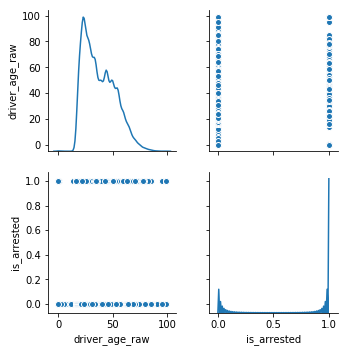

In [87]:
g = sns.pairplot(df3,diag_kind="kde")
plt.show()

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219319 entries, 0 to 219318
Data columns (total 22 columns):
state                    219319 non-null object
stop_date                219319 non-null object
stop_time                219319 non-null object
location_raw             219292 non-null object
county_name              219291 non-null object
county_fips              219291 non-null float64
fine_grained_location    218201 non-null object
police_department        219319 non-null object
driver_gender            219319 non-null object
driver_age_raw           219319 non-null int64
driver_age               219223 non-null float64
driver_race_raw          219319 non-null object
driver_race              219319 non-null object
violation_raw            219319 non-null object
violation                219319 non-null object
search_conducted         219319 non-null bool
search_type_raw          219319 non-null object
search_type              219319 non-null object
contraband_found         2

2228

In [19]:
#data 整形する
df_country_name = pd.get_dummies(df["county_name"])
df_driver_gender = pd.get_dummies(df["driver_gender"])
df_driver_race_raw = pd.get_dummies(df["driver_race_raw"])
df_driver_gender = pd.get_dummies(df["search_conducted"])
df_search_type_raw = pd.get_dummies(df["search_type_raw"])
df_contraband_found = pd.get_dummies(df["contraband_found"])
df_stop_duration = pd.get_dummies(df["stop_duration"])


In [100]:

df_county_name = pd.get_dummies(df["county_name"])

CT
0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17       1
18       1
19       1
20       1
21       1
22       1
23       1
24       1
25       1
26       1
27       1
28       1
29       1
30       1
31       1
32       1
33       1
34       1
35       1
36       1
37       1
38       1
39       1
40       1
41       1
42       1
43       1
44       1
45       1
46       1
47       1
48       1
49       1
50       1
51       1
52       1
53       1
54       1
55       1
56       1
57       1
58       1
59       1
...     ..
219259   1
219260   1
219261   1
219262   1
219263   1
219264   1
219265   1
219266   1
219267   1
219268   1
219269   1
219270   1
219271   1
219272   1
219273   1
219274   1
219275   1
219276   1
219277   1
219278   1
219279   1
219280   1
219281   1
219282   1
219283   1
219284   1
219285   1
219286   1
219287   1
219288   1
219289   1
219290   1
219291   1
219292   1
219293   1
219294   1
219295   1
219296   1
219297   1
219298   1
219299   1
219300   1
219301   1
219302   1
219303   1
219304   1
219305   1
219306   1
219307   1
219308   1
219309   1
219310   1
219311   1
219312   1
219313   1
219314   1
219315   1
219316   1
219317   1
219318   1

[219319 rows x 1 columns]

In [163]:
df_train = pd.concat([df['driver_age_raw'],df_country_name,
                      df_driver_gender,df_driver_race_raw,
                      df_driver_gender,df_search_type_raw,
                      df_contraband_found,df_stop_duration,
                      df_violation,df_county_name,DataFrame(stoptime_num,columns =["stop_time"] )
                      ,df["is_arrested"]],axis = 1)

In [164]:
df_train

driver_age_raw  Fairfield County  Hartford County  Litchfield County  \
0                   46                 0                1                  0   
1                   38                 1                0                  0   
2                   23                 0                0                  0   
3                   23                 0                0                  0   
4                   42                 0                0                  0   
5                   29                 1                0                  0   
6                   22                 0                0                  0   
7                   49                 0                1                  0   
8                   29                 0                0                  0   
9                   37                 1                0                  0   
10                  29                 0                0                  0   
11                  42                 0                0                  0   
12                  33                 0                0                  0   
13                  46                 0                0                  0   
14                  27                 0                0                  0   
15                  70                 0                0                  0   
16                  49                 0                0                  0   
17                  45                 0                0                  0   
18                  30                 0                0                  0   
19                  55                 0                0                  0   
20                  25                 0                0                  0   
21                  74                 0                0                  0   
22                  30                 1                0                  0   
23                  20                 0                0                  0   
24                  43                 0                1                  0   
25                  25                 1                0                  0   
26                  52                 0                0                  1   
27                  36                 0                0                  0   
28                  22                 0                0                  0   
29                  45                 0                0                  0   
30                  62                 0                0                  0   
31                  18                 0                0                  0   
32                  25                 0                0                  0   
33                  40                 0                0                  0   
34                  17                 0                0                  0   
35                  47                 0                0                  0   
36                  25                 0                0                  1   
37                  47                 0                0                  1   
38                  50                 1                0                  0   
39                  47                 0                0                  0   
40                  36                 0                0                  0   
41                  55                 0                0                  1   
42                  32                 0                0                  0   
43                  22                 0                0                  0   
44                  17                 0                0                  1   
45                  22                 0                0                  0   
46                  32                 0                0                  0   
47                  58                 0                0                  0   
48                  71                 0                0                  0   
49      

In [110]:
 #重複データ3つあるらしい
df_train.drop_duplicates(inplace = True)

In [23]:
df_train

driver_age_raw  Fairfield County  Hartford County  Litchfield County  \
0                   46                 0                1                  0   
1                   38                 1                0                  0   
2                   23                 0                0                  0   
3                   23                 0                0                  0   
4                   42                 0                0                  0   
5                   29                 1                0                  0   
6                   22                 0                0                  0   
7                   49                 0                1                  0   
8                   29                 0                0                  0   
9                   37                 1                0                  0   
10                  29                 0                0                  0   
11                  42                 0                0                  0   
12                  33                 0                0                  0   
13                  46                 0                0                  0   
14                  27                 0                0                  0   
15                  70                 0                0                  0   
16                  49                 0                0                  0   
17                  45                 0                0                  0   
18                  30                 0                0                  0   
19                  55                 0                0                  0   
20                  25                 0                0                  0   
21                  74                 0                0                  0   
22                  30                 1                0                  0   
23                  20                 0                0                  0   
24                  43                 0                1                  0   
25                  25                 1                0                  0   
26                  52                 0                0                  1   
27                  36                 0                0                  0   
28                  22                 0                0                  0   
29                  45                 0                0                  0   
30                  62                 0                0                  0   
31                  18                 0                0                  0   
32                  25                 0                0                  0   
33                  40                 0                0                  0   
34                  17                 0                0                  0   
35                  47                 0                0                  0   
36                  25                 0                0                  1   
37                  47                 0                0                  1   
38                  50                 1                0                  0   
39                  47                 0                0                  0   
40                  36                 0                0                  0   
41                  55                 0                0                  1   
42                  32                 0                0                  0   
43                  22                 0                0                  0   
44                  17                 0                0                  1   
45                  22                 0                0                  0   
46                  32                 0                0                  0   
47                  58                 0                0                  0   
48                  71                 0                0                  0   
49      

In [111]:
df_train.drop(['Unnamed: 0'],axis = 1,inplace = True)

In [ ]:
#とりあえずviolation country fip timeは気にしないことにした

In [103]:
#_raw とそれがついていないものはほぼ似たような値が入っていそうなのでとりあえず落として計算してみることにする。


In [113]:
X = df_train.drop(["is_arrested"],axis = 1)

In [114]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)
y = df["is_arrested"]
from sklearn.model_selection import train_test_split
X_rfr_train, X_rfr_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [117]:
from xgboost.sklearn import XGBRegressor
xgr = XGBRegressor()
xgr.fit(X_rfr_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [139]:
import xgboost as xgb

#RandomizedSearchCVでパラメータチューニング
param_distributions={'max_depth': [6,12,16],
                     'subsample': [0.5,0.7,0.9],
                     'colsample_bytree': [0.9],
                     
                     "gamma":[1,10,100],
                     "min_child_weight":[1]
                     
}

xgb_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree')
rs =GridSearchCV(xgb_model,
                        param_distributions,
                        cv=2,
                        scoring="roc_auc",
                        n_jobs=1,
                        verbose=2)
rs.fit(X_rfr_train,y_train)

predictgs = rs.predict(X_rfr_test)
#スコアが見やすいよう整理
resultgs = pd.DataFrame(rs.cv_results_)
result_scoredgs = resultgs.sort_values(by=["rank_test_score"])[["params","mean_test_score","std_test_score","mean_fit_time"]]

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] colsample_bytree=0.9, gamma=1, max_depth=6, min_child_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.9, gamma=1, max_depth=6, min_child_weight=1, subsample=0.5, total=  26.6s
[CV] colsample_bytree=0.9, gamma=1, max_depth=6, min_child_weight=1, subsample=0.5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   27.1s remaining:    0.0s


[CV]  colsample_bytree=0.9, gamma=1, max_depth=6, min_child_weight=1, subsample=0.5, total=  26.6s
[CV] colsample_bytree=0.9, gamma=1, max_depth=6, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=1, max_depth=6, min_child_weight=1, subsample=0.7, total=  24.4s
[CV] colsample_bytree=0.9, gamma=1, max_depth=6, min_child_weight=1, subsample=0.7 
[CV]  colsample_bytree=0.9, gamma=1, max_depth=6, min_child_weight=1, subsample=0.7, total=  24.5s
[CV] colsample_bytree=0.9, gamma=1, max_depth=6, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=1, max_depth=6, min_child_weight=1, subsample=0.9, total=  23.3s
[CV] colsample_bytree=0.9, gamma=1, max_depth=6, min_child_weight=1, subsample=0.9 
[CV]  colsample_bytree=0.9, gamma=1, max_depth=6, min_child_weight=1, subsample=0.9, total=  22.2s
[CV] colsample_bytree=0.9, gamma=1, max_depth=12, min_child_weight=1, subsample=0.5 
[CV]  colsample_bytree=0.9, gamma=1, max_depth=12, min_child_weight=1, subsample=0.5

KeyboardInterrupt: 

AttributeError: 'GridSearchCV' object has no attribute 'best_params'

In [118]:
pred = xgr.predict(X_rfr_test)
from sklearn import metrics as mtr
fpr, tpr, thresholds = mtr.roc_curve(y_test, pred)
mtr.auc(fpr, tpr)

0.8480517840394977

In [129]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver="sgd",random_state=0,max_iter=1000,hidden_layer_sizes = (100,1000,20))
                                                                                    
clf.fit(X_rfr_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 1000, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [130]:
pred = clf.predict_proba(X_rfr_test)[:,1]
fpr, tpr, thresholds = mtr.roc_curve(y_test, pred)
mtr.auc(fpr, tpr)

0.8550532751294458

In [131]:
pred_xg = xgr.predict(X_rfr_test)
pred_mlp = clf.predict_proba(X_rfr_test)[:,1]
pred = 0.5*pred_xg + 0.5*pred_mlp
fpr, tpr, thresholds = mtr.roc_curve(y_test, pred)
mtr.auc(fpr, tpr)

0.856474899056063

In [80]:
from sklearn.model_selection import train_test_split
X_rfr_train, X_rfr_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [81]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=1000)
rfr.fit(X_rfr_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [84]:
pred = rfr.predict(X_rfr_test)

In [85]:
pred

array([4.31585573e-03, 0.00000000e+00, 4.40712242e-03, 0.00000000e+00,
       2.15053763e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.78636060e-03, 0.00000000e+00, 2.31107406e-02, 1.12989937e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.67976190e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.39392228e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.85032717e-02,
       0.00000000e+00, 2.11492534e-02, 0.00000000e+00, 2.28879704e-02,
       0.00000000e+00, 1.04629484e-02, 2.50104965e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.20620931e-02, 0.00000000e+00,
       3.41666667e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.11230330e-02, 0.00000000e+00, 2.43429359e-02, 0.00000000e+00,
       7.15172056e-04, 0.00000000e+00, 8.53500000e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.72953416e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.41788306e-03,
      

In [88]:
from sklearn import metrics as mtr
fpr, tpr, thresholds = mtr.roc_curve(y_test, pred)
mtr.auc(fpr, tpr)

0.7855310150938326

In [ ]:
 import numpy as np
from sklearn import metrics
y = np.array([1, 1, 2, 2])
>>> pred = np.array([0.1, 0.4, 0.35, 0.8])
>>> fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
>>> metrics.auc(fpr, tpr)

In [90]:
#drop_duplicate してやってみる。
df_train_no_dup = df_train.drop_duplicates()
len(df_train_no_dup)

27644

In [94]:
len(df_train.drop(["is_arreted"],axis = 1).drop_duplicates())

27644

In [95]:

X = df_train_no_dup.drop(["is_arrested"],axis = 1)
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)
y = df_train_no_dup["is_arrested"]
from sklearn.model_selection import train_test_split
X_rfr_train, X_rfr_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [96]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=1000)
rfr.fit(X_rfr_train, y_train)
pred = rfr.predict(X_rfr_test)

In [97]:
from sklearn import metrics as mtr
fpr, tpr, thresholds = mtr.roc_curve(y_test, pred)
mtr.auc(fpr, tpr)

0.6792465456633942

In [98]:
from sklearn.svm import SVC
from sklearn.svm import SVR

svc = SVC(kernel='rbf', gamma=0.1, C=10)
svc.fit(X_rfr_train, y_train)
svr = SVR(kernel='rbf', gamma=0.1, C=10)
svr.fit(X_rfr_train, y_train)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [99]:
fpr, tpr, thresholds = mtr.roc_curve(y_test, svr.predict(X_rfr_test))
mtr.auc(fpr, tpr)

0.6924851993631047

In [100]:
df1 = pd.read_csv('train (3).csv')
df_test = pd.read_csv('test (1).csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [101]:
df_test

state   stop_date stop_time      location_raw        county_name  \
0        CT  2014-10-13     07:18            orange   New Haven County   
1        CT  2014-11-25     03:25          woodbury  Litchfield County   
2        CT  2015-03-23     09:32           norwich  New London County   
3        CT  2014-01-01     19:31         watertown  Litchfield County   
4        CT  2014-10-17     04:47         ellington     Tolland County   
5        CT  2013-10-10     16:31          stafford     Tolland County   
6        CT  2014-03-27     13:50           danbury   Fairfield County   
7        CT  2014-06-14     15:10          westport   Fairfield County   
8        CT  2014-12-01     07:20           windham     Windham County   
9        CT  2013-10-17     15:13        farmington    Hartford County   
10       CT  2014-10-13     05:45          franklin  New London County   
11       CT  2014-02-01     16:01          cheshire   New Haven County   
12       CT  2013-11-24     20:47           andover     Tolland County   
13       CT  2014-05-12     05:30           tolland     Tolland County   
14       CT  2014-08-18     19:40           ledyard  New London County   
15       CT  2014-12-13     08:03           danbury   Fairfield County   
16       CT  2014-08-23     14:00     windsor locks    Hartford County   
17       CT  2014-01-31     23:52         westbrook   Middlesex County   
18       CT  2014-04-28     17:09          thompson     Windham County   
19       CT  2015-01-23     07:25  north stonington  New London County   
20       CT  2014-03-14     08:29            oxford   New Haven County   
21       CT  2014-11-07     10:40          stafford     Tolland County   
22       CT  2015-03-30     06:18           chester   Middlesex County   
23       CT  2014-12-22     12:59        manchester    Hartford County   
24       CT  2015-01-20     12:16           norwalk   Fairfield County   
25       CT  2015-01-28     10:04       marlborough    Hartford County   
26       CT  2013-11-29     21:27        brookfield   Fairfield County   
27       CT  2014-01-29     14:06        new london  New London County   
28       CT  2014-04-29     05:44        bridgeport   Fairfield County   
29       CT  2014-08-16     01:47        bridgeport   Fairfield County   
30       CT  2015-02-24     09:47      wethersfield    Hartford County   
31       CT  2014-11-03     10:37         killingly     Windham County   
32       CT  2013-12-09     07:02         killingly     Windham County   
33       CT  2014-09-08     05:12          prospect   New Haven County   
34       CT  2014-12-08     12:25          westport   Fairfield County   
35       CT  2015-02-26     04:59            vernon     Tolland County   
36       CT  2014-09-03     21:01        canterbury     Windham County   
37       CT  2015-01-09     02:01         harwinton  Litchfield County   
38       CT  2015-03-20     07:44           meriden   New Haven County   
39       CT  2013-11-19     11:08         killingly     Windham County   
40       CT  2014-11-14     05:26         waterford  New London County   
41       CT  2015-03-04     05:27           madison   New Haven County   
42       CT  2014-10-05     11:05     east hartford    Hartford County   
43       CT  2013-10-04     04:48           windham     Windham County   
44       CT  2014-03-11     11:24          griswold  New London County   
45       CT  2014-10-07     12:13          hartford    Hartford County   
46       CT  2013-10-02     09:20           tolland     Tolland County   
47       CT  2014-12-27     09:49         westbrook   Middlesex County   
48       CT  2015-02-13     11:57         killingly     Windham County   
49       CT  2014-01-06     08:42         new haven   New Haven County   
50       CT  2014-07-09     08:18        litchfield  Litchfield County   
51       CT  2014-04-24     07:59             union     Tolland County   
52       CT  2014-02-12     14:13            vernon     Tolland County   
53       C

In [198]:
df_test = pd.read_csv('test (1).csv')

In [11]:
df_violation_test = df_test["violation"]

In [13]:
#!!!コードとしては正しいけど処理がめっちゃ重くてすごく時間がかかるので注意しましょう!!!!
df_new_test = pd.DataFrame(columns = vio, index = np.arange(0,len(df_test)))

for i in range (0,len(df_violation_test)):
    for j in range (0,len(vio)):
        if df_violation_test[i].find(vio[j]) != -1:
            df_new_test[vio[j]][i] = 1
        else :
            df_new_test[vio[j]][i] = 0

In [14]:
df_new_test.to_csv("df_violation_test")

In [199]:
df_test["search_type_raw"].fillna(0,inplace =True)

In [200]:
df_country_name_test = pd.get_dummies(df_test["county_name"])
df_driver_gender_test = pd.get_dummies(df_test["driver_gender"])
df_driver_race_raw_test = pd.get_dummies(df_test["driver_race_raw"])
df_driver_gender_test = pd.get_dummies(df_test["search_conducted"])
df_search_type_raw_test = pd.get_dummies(df_test["search_type_raw"])
df_contraband_found_test = pd.get_dummies(df_test["contraband_found"])
df_stop_duration_test = pd.get_dummies(df_test["stop_duration"])
df_county_name = pd.get_dummies(df_test["county_name"])

In [183]:
# stoptime使うのは諦めざるを得なかった。
df_test["stop_time"] = df_test["stop_time"].fillna("00:-1")
stoptime_num_test =np.zeros(len(df_test), dtype = float )

for i in range (0,len(df_test)):
    stoptime_num_test[i] = float(df_test["stop_time"][i][0:2]) +  float(df_test["stop_time"][i][3:5]) /60

In [184]:
for i in range (0,len(df_test)):
    if stoptime_num[i] < 0:
        stoptime_num[i] = stoptime_num.mean()



In [201]:
df_test = pd.concat([df_test['driver_age_raw'],df_country_name_test,
                      df_driver_gender_test,df_driver_race_raw_test,df_driver_gender_test,
                df_search_type_raw_test,df_contraband_found_test
                      ,df_stop_duration_test,df_new_test,df_county_name,DataFrame(stoptime_num_test,columns = ["stoptime"])],axis = 1)                                                


In [202]:
df_test

driver_age_raw  Fairfield County  Hartford County  Litchfield County  \
0                  42                 0                0                  0   
1                  59                 0                0                  1   
2                  42                 0                0                  0   
3                  30                 0                0                  1   
4                  24                 0                0                  0   
5                  42                 0                0                  0   
6                  59                 1                0                  0   
7                  29                 1                0                  0   
8                  81                 0                0                  0   
9                  71                 0                1                  0   
10                 25                 0                0                  0   
11                 49                 0                0                  0   
12                 47                 0                0                  0   
13                 58                 0                0                  0   
14                 25                 0                0                  0   
15                 46                 1                0                  0   
16                 51                 0                1                  0   
17                 21                 0                0                  0   
18                 25                 0                0                  0   
19                 75                 0                0                  0   
20                 26                 0                0                  0   
21                 30                 0                0                  0   
22                 27                 0                0                  0   
23                 32                 0                1                  0   
24                 20                 1                0                  0   
25                 33                 0                1                  0   
26                 19                 1                0                  0   
27                 57                 0                0                  0   
28                 27                 1                0                  0   
29                 30                 1                0                  0   
30                 36                 0                1                  0   
31                 27                 0                0                  0   
32                 26                 0                0                  0   
33                 20                 0                0                  0   
34                 25                 1                0                  0   
35                 23                 0                0                  0   
36                 54                 0                0                  0   
37                 25                 0                0                  1   
38                 67                 0                0                  0   
39                 47                 0                0                  0   
40                 41                 0                0                  0   
41                 54                 0                0                  0   
42                 20                 0                1                  0   
43                 57                 0                0                  0   
44                 20                 0                0                  0   
45                 48                 0                1                  0   
46                 64                 0                0                  0   
47                 39                 0                0                  0   
48                 19                 0                0                  0   
49                 59                 0                0 

In [191]:
df_train

driver_age_raw  Fairfield County  Hartford County  Litchfield County  \
0                   46                 0                1                  0   
1                   38                 1                0                  0   
2                   23                 0                0                  0   
3                   23                 0                0                  0   
4                   42                 0                0                  0   
5                   29                 1                0                  0   
6                   22                 0                0                  0   
7                   49                 0                1                  0   
8                   29                 0                0                  0   
9                   37                 1                0                  0   
10                  29                 0                0                  0   
11                  42                 0                0                  0   
12                  33                 0                0                  0   
13                  46                 0                0                  0   
14                  27                 0                0                  0   
15                  70                 0                0                  0   
16                  49                 0                0                  0   
17                  45                 0                0                  0   
18                  30                 0                0                  0   
19                  55                 0                0                  0   
20                  25                 0                0                  0   
21                  74                 0                0                  0   
22                  30                 1                0                  0   
23                  20                 0                0                  0   
24                  43                 0                1                  0   
25                  25                 1                0                  0   
26                  52                 0                0                  1   
27                  36                 0                0                  0   
28                  22                 0                0                  0   
29                  45                 0                0                  0   
30                  62                 0                0                  0   
31                  18                 0                0                  0   
32                  25                 0                0                  0   
33                  40                 0                0                  0   
34                  17                 0                0                  0   
35                  47                 0                0                  0   
36                  25                 0                0                  1   
37                  47                 0                0                  1   
38                  50                 1                0                  0   
39                  47                 0                0                  0   
40                  36                 0                0                  0   
41                  55                 0                0                  1   
42                  32                 0                0                  0   
43                  22                 0                0                  0   
44                  17                 0                0                  1   
45                  22                 0                0                  0   
46                  32                 0                0                  0   
47                  58                 0                0                  0   
48                  71                 0                0                  0   
49      

In [ ]:
df_trai

In [203]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(df_test)


In [ ]:
df_test.drop([""],axis = 1)

In [204]:
pred_xg = xgr.predict(X_scaled)
pred_mlp = clf.predict_proba(X_scaled)[:,1]
 


predict_value =  0.5*pred_xg + 0.5*pred_mlp

In [218]:
predict_value1 = DataFrame(predict_value,columns = ["is_arrested"])

In [221]:
predict_value

array([ 0.01134228,  0.00841383,  0.45011669,  0.00720834,  0.0317176 ,
        0.00903937,  0.00365208,  0.00960484,  0.01702353,  0.00871237,
        0.00809785,  0.00816873,  0.00988146,  0.00923335,  0.01477811,
        0.00451478,  0.00444882,  0.00881137,  0.01388734,  0.017372  ,
        0.00930654,  0.01031871,  0.00976864,  0.00478851,  0.00332496,
        0.00503679,  0.00360096,  0.02684418,  0.00875874,  0.04924343,
        0.00694302,  0.00891956,  0.00836495,  0.0058026 ,  0.00684118,
        0.00615024,  0.00616716,  0.0080198 ,  0.00792616,  0.00577741,
        0.01941421,  0.00525754,  0.01415564,  0.18078137,  0.01328568,
        0.01242891,  0.00301491,  0.01250689,  0.14241416,  0.01314968,
        0.00581821,  0.00668719,  0.00792055,  0.00980689,  0.01740294,
        0.01502282,  0.00318622,  0.013046  ,  0.02257964,  0.00694982,
        0.00655067,  0.00676159,  0.02619332,  0.00644966,  0.21659103,
        0.0083028 ,  0.01865689,  0.01353757,  0.00519107,  0.00

In [220]:
predict_value1.to_csv("predict_value1",index = False)

In [74]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93994 entries, 0 to 93993
Data columns (total 21 columns):
state                    93994 non-null object
stop_date                93994 non-null object
stop_time                93936 non-null object
location_raw             93983 non-null object
county_name              93983 non-null object
county_fips              93983 non-null float64
fine_grained_location    93509 non-null object
police_department        93994 non-null object
driver_gender            93994 non-null object
driver_age_raw           93994 non-null int64
driver_age               93945 non-null float64
driver_race_raw          93994 non-null object
driver_race              93994 non-null object
violation_raw            93994 non-null object
violation                93994 non-null object
search_conducted         93994 non-null bool
search_type_raw          1415 non-null object
search_type              1415 non-null object
contraband_found         93994 non-null bool
off

In [98]:
df_train

1118

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(iris.data, iris.target)
score = clf.score(iris.data, iris.target)

In [ ]:
#classification_report のクラスの読み込み
from sklearn import metrics as mtr
#予測
y_pred = clf.predict()
#分類結果の表示
print(mtr.classification_report(, , ))

In [ ]:
prob = clf.predict_proba(iris.data)[:,2]
fpr, tpr, thresholds = mtr.roc_curve(iris.target, prob, pos_label=2)

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [ ]:
mtr.auc(fpr, tpr)